In [1]:
import os
import itertools
import shutil
import random
import glob
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
random.seed(123)

Check that GPU acceleration is being used

In [3]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


Set paths

In [4]:
training_data_path = "../data/training_images"
validation_data_path = "../data/validation_images"
test_data_path = "../data/test_images"

Image preprocessing

In [5]:
training_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = training_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10)
    
validation_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = validation_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10)
    
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = test_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10, shuffle = False)

Found 12195 images belonging to 4 classes.
Found 431 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Preprocess a image batch

In [6]:
imgs, labels = next(training_batches)

Image batch plotting function

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Plot and print labels for the preprocessed image batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

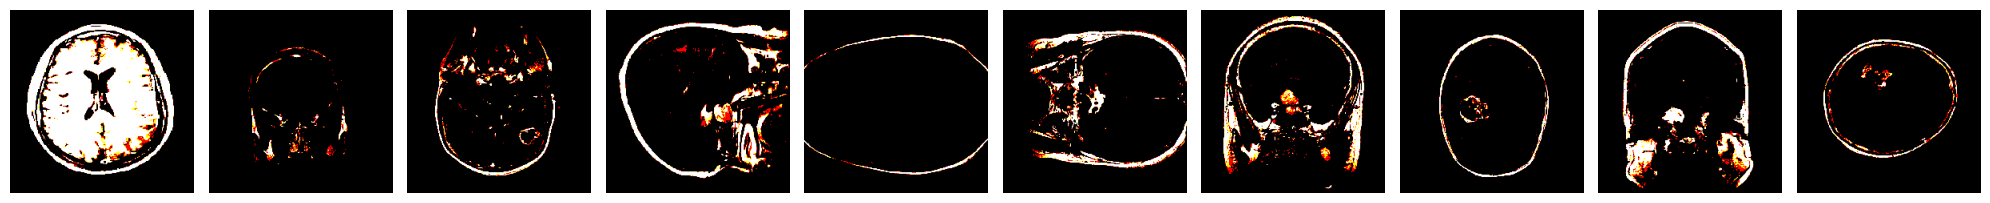

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
plotImages(imgs)
print(labels)

Build model

In [9]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", padding = "same", input_shape = (230,230,3)), 
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = "same",),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Flatten(),
    Dense(units = 4, activation = "softmax")
    ])

2024-03-15 16:21:48.167449: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-15 16:21:48.167474: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-03-15 16:21:48.167483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-03-15 16:21:48.167521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 16:21:48.167539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
model = Sequential([
    Conv2D(filters = 64, kernel_size = (4,4), activation = "relu", padding = "same", input_shape = (230,230,3)), 
    MaxPool2D(pool_size = (4,4), strides = 2),
    Conv2D(filters = 128, kernel_size = (4,4), activation = "relu", padding = "same",),
    MaxPool2D(pool_size = (4,4), strides = 2),
    Conv2D(filters = 64, kernel_size = (4,4), activation = "relu", padding = "same",),
    MaxPool2D(pool_size = (4,4), strides = 2),
     Conv2D(filters = 32, kernel_size = (4,4), activation = "relu", padding = "same",),
    MaxPool2D(pool_size = (4,4), strides = 2),
    Flatten(),
    Dense(units = 4, activation = "softmax")
    ])

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 230, 230, 64)      3136      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 114, 114, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 114, 114, 128)     131200    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 64)        131136    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 27, 27, 64)       

In [20]:
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [21]:
model.fit(x = training_batches,
          validation_data = validation_batches,
          epochs = 20)

Epoch 1/20


2024-03-15 16:36:27.899254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1220/1220 [==============================] - 33s 27ms/step - loss: 1.2256 - accuracy: 0.6084 - val_loss: 0.7386 - val_accuracy: 0.6845
Epoch 2/20
1220/1220 [==============================] - 32s 27ms/step - loss: 0.6497 - accuracy: 0.7493 - val_loss: 0.5756 - val_accuracy: 0.7541
Epoch 3/20
1220/1220 [==============================] - 32s 27ms/step - loss: 0.4910 - accuracy: 0.8175 - val_loss: 0.5164 - val_accuracy: 0.8028
Epoch 4/20
1220/1220 [==============================] - 32s 27ms/step - loss: 0.3732 - accuracy: 0.8609 - val_loss: 0.5676 - val_accuracy: 0.7981
Epoch 5/20
1220/1220 [==============================] - 32s 27ms/step - loss: 0.2966 - accuracy: 0.8918 - val_loss: 0.5579 - val_accuracy: 0.8097
Epoch 6/20
1220/1220 [==============================] - 33s 27ms/step - loss: 0.2415 - accuracy: 0.9123 - val_loss: 0.5004 - val_accuracy: 0.8329
Epoch 7/20
1220/1220 [==============================] - 32s 27ms/step - loss: 0.1900 - accuracy: 0.9307 - val_loss: 0.5096 - val_accura